# Apparel Recommendations using Convolutional Neural Network

## Get the feature vectors of all apparel images

In [1]:
import numpy as np
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd

import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
import numpy as np


In [3]:
# dimensions of our images.
img_width, img_height = 224, 224
train_data_dir = 'images/'  # Make sure this path is correct
# nb_train_samples = 16042
nb_train_samples = 16121
batch_size = 1

In [4]:
import os

# Specify the folder path
train_data_dir = 'images/'

# Count the number of image files
image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')  # Add other extensions if needed
image_count = sum(1 for file in os.listdir(train_data_dir) if file.lower().endswith(image_extensions))

print(f"Number of images in the folder: {image_count}")


Number of images in the folder: 16121


In [5]:
def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(f"Found {generator.samples} images.")  # Debugging generator

    for i in generator.filenames:
        asins.append(i[2:-5])

    # Ensure the generator is yielding samples
    if generator.samples > 0:
        bottleneck_features_train = model.predict(generator, steps=nb_train_samples // batch_size)
        
        print(f"Bottleneck features shape: {bottleneck_features_train.shape}")  # Debugging output shape
        
        # Reshape based on actual output size
        bottleneck_features_train = bottleneck_features_train.reshape(bottleneck_features_train.shape[0], -1)

        # np.save(open('models/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
        # np.save(open('models/16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    else:
        print("No images found. Please check the data directory.")

save_bottlebeck_features()


Found 180 images belonging to 2 classes.
Found 180 images.


C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16121/16121 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step      
Bottleneck features shape: (180, 7, 7, 512)


C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


# load the extracted features

In [6]:
# bottleneck_features_train = np.load('workshop/models/16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')

## get the most similar apparels using euclidean distance measure

In [7]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])
asins = list(asins)

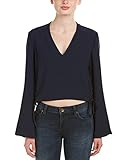

Product Title:  finders keepers womens fly away top 
Euclidean Distance from input image: 4.0460973e-06
Amazon Url: www.amazon.com/dp/B01N3SAT0R


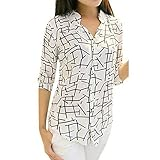

Product Title:  fire womens longsleeve print chiffon fashion slim blouses large white 
Euclidean Distance from input image: 14.919009
Amazon Url: www.amazon.com/dp/B00ZZR0UGC


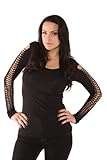

Product Title:  folter clothing black open braided arm top sexy top womens sizes medium 
Euclidean Distance from input image: 23.578989
Amazon Url: www.amazon.com/dp/B0085GF3CQ


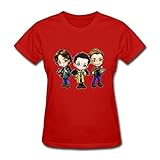

Product Title:  supernatural chibis sam dean castiel short sleeve shirts women red xs 
Euclidean Distance from input image: 30.638746
Amazon Url: www.amazon.com/dp/B014ICBSE2


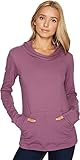

Product Title:  fig clothing womens dublin top macaroon shirt 
Euclidean Distance from input image: 31.731806
Amazon Url: www.amazon.com/dp/B01MU4SW99


In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from IPython.display import display, Image

# Load your preprocessed data
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
asins = data['asin'].tolist()  # Assuming 'asin' is the column with ASINs

# Load the bottleneck features
bottleneck_features_train = np.load('16k_data_cnn_features.npy')

def get_similar_products_cnn(doc_id, num_results, bottleneck_features_train):
    # Get the index of the document ID in the asins list
    doc_id = asins.index(data['asin'].iloc[doc_id])
    
    # Calculate pairwise distances
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1, -1))

    # Get the indices of the closest products
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists = np.sort(pairwise_dist.flatten())[0:num_results]

    # Display results
    for i in range(len(indices)):
        rows = data[['medium_image_url', 'title']].loc[data['asin'] == asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amazon.com/dp/' + asins[indices[i]])

# Call the function with the desired document ID and number of results
get_similar_products_cnn(55, 5, bottleneck_features_train)

